## This part is worth 30% of your grade. A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer #word stemmer class
lemma = WordNetLemmatizer()

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding

In [2]:
import json
from pandas.io.json import json_normalize

# 1. Data Preparation
## 1.1 Load data
I first loaded all the data, including the raw JSON file, and check each table to understand the structure better. Then, normalize and rename the columns. I also merged it with the identification data.

In [3]:
# read files 
data_identification = pd.read_csv("../input/dm2021-lab2-hw2/data_identification.csv")
emotion = pd.read_csv("../input/dm2021-lab2-hw2/emotion.csv")
sampleSubmission = pd.read_csv("../input/dm2021-lab2-hw2/sampleSubmission.csv")
raw_data = pd.read_json("../input/dm2021-lab2-hw2/tweets_DM.json", lines=True,orient='columns')

In [4]:
# check the identification data
data_identification[:10]

,tweet_id,identification
0,0x28cc61,test
1,0x29e452,train
2,0x2b3819,train
3,0x2db41f,test
4,0x2a2acc,train
5,0x2a8830,train
6,0x20b21d,train
7,0x2452cf,train
8,0x2d729d,train
9,0x2ab56d,train


In [5]:
# check emotion data
emotion[:10]

,tweet_id,emotion
0,0x3140b1,sadness
1,0x368b73,disgust
2,0x296183,anticipation
3,0x2bd6e1,joy
4,0x2ee1dd,anticipation
5,0x34cd80,joy
6,0x33f099,sadness
7,0x2ae7b7,sadness
8,0x2408d4,trust
9,0x2b193b,sadness


In [6]:
# check the raw data        
raw_data[:10]

,_score,_index,_source,_crawldate,_type
0,391,hashtag_tweets,"{'tweet': {'hashtags': ['Snapchat'], 'tweet_id...",2015-05-23 11:42:47,tweets
1,433,hashtag_tweets,"{'tweet': {'hashtags': ['freepress', 'TrumpLeg...",2016-01-28 04:52:09,tweets
2,232,hashtag_tweets,"{'tweet': {'hashtags': ['bibleverse'], 'tweet_...",2017-12-25 04:39:20,tweets
3,376,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x1cd5...",2016-01-24 23:53:05,tweets
4,989,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2de2...",2016-01-08 17:18:59,tweets
5,120,hashtag_tweets,"{'tweet': {'hashtags': ['authentic', 'LaughOut...",2015-06-11 04:44:05,tweets
6,1021,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2c91...",2015-08-18 02:30:07,tweets
7,481,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x368e...",2015-08-20 14:31:27,tweets
8,827,hashtag_tweets,"{'tweet': {'hashtags': ['LeagueCup'], 'tweet_i...",2016-04-18 13:01:02,tweets
9,66,hashtag_tweets,"{'tweet': {'hashtags': ['materialism', 'money'...",2015-09-09 09:22:55,tweets


In [7]:
# split the _source columns
df = pd.json_normalize(data=raw_data['_source'])

# rename column names of source
df=df.rename(index=str,columns={"tweet.text":"text", "tweet.tweet_id":"tweet_id","tweet.hashtags":"hashtags"})

In [8]:
# check normalized and renamed raw data
df[:10]

,hashtags,tweet_id,text
0,[Snapchat],0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,"[freepress, TrumpLegacy, CNN]",0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,[bibleverse],0x28b412,"Confident of your obedience, I write to you, k..."
3,[],0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,[],0x2de201,"""Trust is not the same as faith. A friend is s..."
5,"[authentic, LaughOutLoud]",0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...
6,[],0x2c91a8,Still waiting on those supplies Liscus. <LH>
7,[],0x368e95,Love knows no gender. 😢😭 <LH>
8,[LeagueCup],0x249c0c,@DStvNgCare @DStvNg More highlights are being ...
9,"[materialism, money, possessions]",0x218443,When do you have enough ? When are you satisfi...


In [9]:
# add identification the dataframe
df=pd.merge(df,data_identification, on="tweet_id")

## 1.2 Clean the text column
Once the data has correct structure, I preprocess it by cleaning the text (lowercase, remove punctuation, remove extra spaces, etc.) and using a tokenizer to tokenize the clean texts. Moreover, to distinguish the training and testing dataset, I split the data based on the identification value (train or test) and print it again to check if it the separation is correct.

In [10]:
# clean the tdext
import re
from string import punctuation

def preprocess_text(text):
    text = text.lower()  #  lowercase text
    text = re.sub(f"[{re.escape(punctuation)}]", "", text)  # remove punctuation
    text = " ".join(text.split())  # remove extra spaces, tabs, and new lines
    return text

df['text'] = df['text'].map(preprocess_text)

In [11]:
# check the clean text
df[:10]

,hashtags,tweet_id,text,identification
0,[Snapchat],0x376b20,people who post add me on snapchat must be deh...,train
1,"[freepress, TrumpLegacy, CNN]",0x2d5350,brianklaas as we see trump is dangerous to fre...,train
2,[bibleverse],0x28b412,confident of your obedience i write to you kno...,test
3,[],0x1cd5b0,now issa is stalking tasha 😂😂😂 lh,train
4,[],0x2de201,trust is not the same as faith a friend is som...,test
5,"[authentic, LaughOutLoud]",0x1d755c,riskshow thekevinallison thx for the best time...,train
6,[],0x2c91a8,still waiting on those supplies liscus lh,train
7,[],0x368e95,love knows no gender 😢😭 lh,train
8,[LeagueCup],0x249c0c,dstvngcare dstvng more highlights are being sh...,train
9,"[materialism, money, possessions]",0x218443,when do you have enough when are you satisfied...,test


In [12]:
max_length = df.text.apply(lambda x: len(x.split())).max()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
df['tokenized_text'] = tokenizer.texts_to_sequences(df['text'])
df['tokenized_text'] = list(pad_sequences(df['tokenized_text'], maxlen = max_length, padding='post'))

vocab_size = max([max(sublist) for sublist in df['tokenized_text'].values])+1 

In [13]:
# split into train and test dataset
train_df = df[df['identification']=='train']
train_df = pd.merge(train_df, emotion, on='tweet_id')

test_df = df[df['identification']=='test']
test_df["emotion"]=""

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
# drop the identification and hashtags column
train_df = train_df.drop(['identification'], axis=1)
test_df = test_df.drop(['identification'], axis=1)
train_df = train_df.drop(['hashtags'], axis=1)
test_df = test_df.drop(['hashtags'], axis=1)

In [15]:
train_df[:10]

,tweet_id,text,tokenized_text,emotion
0,0x376b20,people who post add me on snapchat must be deh...,"[58, 62, 552, 1075, 17, 13, 1131, 285, 18, 205...",anticipation
1,0x2d5350,brianklaas as we see trump is dangerous to fre...,"[14038, 51, 30, 73, 206, 8, 2490, 3, 32779, 25...",sadness
2,0x1cd5b0,now issa is stalking tasha 😂😂😂 lh,"[59, 587, 8, 6629, 2390, 942, 1, 0, 0, 0, 0, 0...",fear
3,0x1d755c,riskshow thekevinallison thx for the best time...,"[112380, 186445, 1811, 9, 2, 105, 60, 163, 34,...",joy
4,0x2c91a8,still waiting on those supplies liscus lh,"[90, 323, 13, 173, 5861, 313334, 1, 0, 0, 0, 0...",anticipation
5,0x368e95,love knows no gender 😢😭 lh,"[29, 585, 49, 3558, 21535, 1, 0, 0, 0, 0, 0, 0...",joy
6,0x249c0c,dstvngcare dstvng more highlights are being sh...,"[95836, 41293, 67, 6005, 19, 117, 2756, 101, 1...",sadness
7,0x359db9,the ssm debate lh a manufactured fantasy used ...,"[2, 12635, 3209, 1, 5, 25509, 1780, 472, 3, 57...",anticipation
8,0x23b037,i love suffering 🙃🙃 i love when valium does no...,"[4, 29, 1841, 11519, 4, 29, 31, 35867, 189, 18...",joy
9,0x1fde89,can someone tell my why my feeds scroll back t...,"[44, 142, 247, 12, 78, 12, 5347, 7972, 87, 3, ...",anger


In [16]:
test_df[:10]

,tweet_id,text,tokenized_text,emotion
2,0x28b412,confident of your obedience i write to you kno...,"[2975, 10, 16, 3617, 4, 903, 3, 7, 906, 15, 7,...",
4,0x2de201,trust is not the same as faith a friend is som...,"[365, 8, 27, 2, 211, 51, 231, 5, 296, 8, 142, ...",
9,0x218443,when do you have enough when are you satisfied...,"[31, 41, 7, 23, 313, 31, 19, 7, 3872, 8, 7, 82...",
30,0x2939d5,god woke you up now chase the day godsplan god...,"[53, 497, 7, 36, 59, 2520, 2, 40, 13077, 21221...",
33,0x26289a,in these tough times who do you turn to as you...,"[11, 176, 1274, 298, 62, 41, 7, 505, 3, 51, 16...",
35,0x31c6e0,turns out you can recognise people by their un...,"[1303, 47, 7, 44, 9442, 58, 56, 108, 20034, 1,...",
37,0x32edee,i like how hayvens mommy daddy and the keyboar...,"[4, 38, 55, 186448, 4074, 1538, 6, 2, 6915, 40...",
46,0x3714ee,i just love it when every single one of my son...,"[4, 25, 29, 14, 31, 136, 513, 48, 10, 12, 916,...",
49,0x235628,juliechen when can we expect a season of celeb...,"[15369, 31, 44, 30, 925, 5, 269, 10, 25511, 4,...",
56,0x283024,tbh regret hurts more than stepping on a lego lh,"[2178, 1979, 1734, 67, 101, 5519, 13, 5, 9090,...",


## 1.4 Save data in Pickle
Because our data is huge, we will save our data on pickle so that it could use less space to store also consume less loading time.


In [17]:
# save to pickle file, for speed
train_df.to_pickle("train_df.pkl") 
test_df.to_pickle("test_df.pkl")

# load a pickle file
train_df = pd.read_pickle("train_df.pkl")
test_df = pd.read_pickle("test_df.pkl")

## 1.5 Exploratory Data Analysis (EDA)
We need to explore a little bit and understand the data we're dealing with. First, we find the distribution of the emotion of each tweet (or text) and create a histogram.

In [18]:
#group to find distribution
train_df.groupby(['emotion']).count()['text']

emotion
anger            39867
anticipation    248935
disgust         139101
fear             63999
joy             516017
sadness         193437
surprise         48729
trust           205478
Name: text, dtype: int64

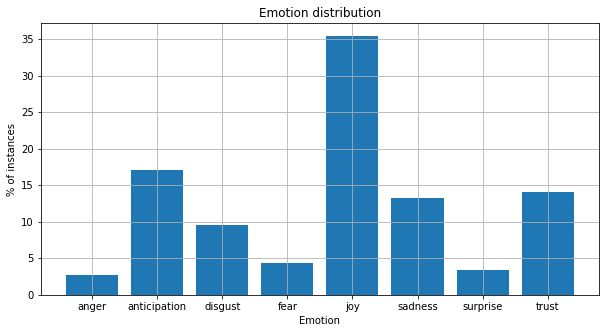

In [19]:
# the histogram of the data
labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

# 2. Split training and testing data
To train the data, we will first split it into training and validation (test) data. Afterwards, rather than put the emotion column directly into a model, we have to process these categorical (or say nominal) label by ourselves. Here, we use the basic method **one-hot encoding** to transform our categorical labels to numerical ones.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop('emotion', axis=1), train_df['emotion'], random_state=1)

In [21]:
# take a look at data dimension
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (1091672, 3)
y_train.shape:  (1091672,)
X_test.shape:  (363891, 3)
y_test.shape:  (363891,)


In [22]:
print(train_df.shape)
print(test_df.shape)

(1455563, 4)
(411972, 4)


In [23]:
# deal with label (string -> one-hot)

import keras
from keras import utils as np_utils
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:8]:\n', y_train[0:8])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.np_utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

check label:  ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']

## Before convert
y_train[0:8]:
 100029     anticipation
991903            trust
518044             fear
215914              joy
267503          sadness
33598               joy
813853          disgust
1366138         disgust
Name: emotion, dtype: object

y_train.shape:  (1091672,)
y_test.shape:  (363891,)


# 3. Feature Engineering
## 3.1 Read GloVe Embedding
For the deep neural models, we need embeddings for the text. Embeddings capture the representation of the word in higher dimensional plane. Through embeddings, we create a vector representation of the word which is learned by understanding the context of words. In this competition, I'm using **glove-twitter-embeddings**. The reason is because this embeddings are speficially trained on billion of twitter documents, which is suitable for our tweets sentiment analysis and it provides different dimensions for us to choose.

In [24]:
embeddings_index = dict()
f = open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [25]:
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


## 3.2 Create embedding
For the bidirectional LSTM we have an embedding layer and instead of loading random weight we will load the weights from our glove embeddings.

In [26]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# 4. Model
## 4.1 Model Building
Bidirectional long-short term memory (BiLSTM) is the process of making any neural network o have the sequence information in both directions backwards (future to past) or forward (past to future) . The idea behind bi-directional network is to capture information of surrounding inputs. It usually learns faster than one-directional approach although it depends on the task.

In [27]:
X_train.dtypes

tweet_id          object
text              object
tokenized_text    object
dtype: object

In [28]:
train_df.dtypes

tweet_id          object
text              object
tokenized_text    object
emotion           object
dtype: object

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Bidirectional, LSTM, GlobalMaxPool1D

output_shape = len(label_encoder.classes_)

model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length = max_length))
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
model.add(GlobalMaxPool1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(output_shape, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

batch_size = 128
model.fit(np.stack(X_train['tokenized_text'].to_numpy(), axis=0), y_train, epochs = 1,
          batch_size=batch_size, 
          validation_data = (np.stack(X_test['tokenized_text'].to_numpy(),axis=0), y_test),
          verbose = 1)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 59, 100)           123655000 
_________________________________________________________________
bidirectional (Bidirectional (None, 59, 256)           234496    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

2021-12-23 12:55:57.641906: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


8529/8529 [==============================] - 13965s 2s/step - loss: 1.3097 - accuracy: 0.5301 - val_loss: 1.1655 - val_accuracy: 0.5798


### 4.2 Predict sentiment for test data

In [30]:
test_df['emotion'] = label_decode(label_encoder, model.predict(np.stack(test_df['tokenized_text'].to_numpy(),axis=0)))

In [31]:
output = test_df[['tweet_id', 'emotion']].copy()
output = output.set_axis(["id", "emotion"], axis=1)
output.to_csv("glove-bilstm.csv", index=False)
output

,id,emotion
2,0x28b412,anticipation
4,0x2de201,anticipation
9,0x218443,joy
30,0x2939d5,anticipation
33,0x26289a,trust
...,...,...
1867525,0x2913b4,anticipation
1867529,0x2a980e,trust
1867530,0x316b80,sadness
1867531,0x29d0cb,sadness


# 5. Other things I've tried
* BOW features, Naive Bayes (initial version): 0.43757
* TF-IDF features, Naive Bayes (initial version): 0.44442
* TF-IDF features, Logistic Regression: 0.45136
* BOW features, Deep Neural Network: 0.44067

The result of logistic regression is relatively good. It is easier to implement, interpret, and very efficient to train. It is very fast at classifying unknown records. Moreover, I tried to work with TF-IDF features on DNN. However, there were some compatibility issues. I got an error that was asking me to use `tf.sparse.reorder` to create a correctly ordered copy. When I used it, there was another error message saying that "Input must be a SparseTensor". I tried using todense() on the TF-IDF output. It seems to work but my 16GB RAM was not able to allocate the array.